In [1]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install string
!pip3 install nltk
!pip3 install numpy
!pip3 install sklearn
!pip3 install xgboost
!pip3 install emoji
!pip3 install shap
!pip3 install gc
!pip3 install os
!pip3 install shap
!pip3 install re
!pip3 install matplotlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [19]:
pip install numba --upgrade

You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.4.3/libexec/bin/python3.10 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

import emoji 
import shap as shap

import gc
import os

/opt/homebrew/Cellar/jupyterlab/3.4.3/libexec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk; nltk.download('popular')
from nltk.corpus import wordnet as wn


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/maretamasaeva/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maretamasaeva/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maretamasaeva/nltk_data...
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/maretamasaeva/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/maretamasaeva/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/maretamasaeva/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]

In [7]:
#drive.mount('/content/gdrive')
#data_path = 'gdrive/MyDrive/THESIS/datasets'

df_balanced = pd.read_csv('datasets/prepped_data/df_balanced.csv')
comparison_file = pd.read_csv('datasets/comparison_file.csv')

In [8]:
df_balanced.head()

,Unnamed: 0,sentence,label
0,136,AITA when someone interrupts me when I am spea...,0
1,464,I greeted her with a slap in the face.,0
2,555,AITA for demanding my Tinder date to pay half ...,0
3,731,"My son is anxious about swimming in the ocean,...",0
4,865,I fed the tigers prepared human meat from the ...,0


In [9]:
comparison_file.head()

,sentence
0,Drinking coffee.
1,Drinking coffee if you’re pregnant.
2,Drinking coffee if you’re a Mormon.
3,Drinking coffee if you’re a democrat.
4,Applying to minority scholarships.


In [10]:
def preprocessor(data):
  pattern = r'(@\w+)|(#\w+)' # (http://[^"\s]+)|
  data['original_sentence'] = data['sentence']
  data['sentence'].str.replace(pattern, "")
  data['sentence'].str.replace('RT', "")
  data['sentence'].str.replace('AITA', "")

  data['sentence'].str.replace('bc', "because")

  # remove usernames
  data['sentence'] = [re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)", "", s) for s in data['sentence']]

  # remove URLs
  data['sentence'] = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", s) for s in data['sentence']]

  # convert (non) emoji smiley faces & emoticons to words
  eyes = '[8:=;]'
  nose = "['`\-~]"

  data['sentence'] = [re.sub(f'{eyes}{nose}*[)]]+|[[(c]+{nose}*{eyes}', 'smile', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[pP]+', 'lolface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[(c\/]+|[)\/]+{nose}*{eyes}', 'sadface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[\|l]+', 'neutralface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[oO$s@&]+', 'otherface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(<3)', 'heart', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(</3)', 'brokenheart', s) for s in data['sentence']]

  data['sentence'] = [emoji.demojize(s) for s in data['sentence']]

  # remove digits
  # data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))
  data['sentence'] = [re.sub(r'[0-9\.]+', '', s) for s in data['sentence']]

  df_balanced['sentence'] = df_balanced['sentence'].str.replace('\d+', '')


  # lowercase
  data['sentence'] = [sentence.lower() for sentence in data['sentence']]

  data['sentence'].str.replace('aita', "")


  # remove punctuation
  data['sentence'] = [re.sub(r'[^\w\d\s\']+', '', s) for s in data['sentence']]

  # remove stopwords
  stops = set(stopwords.words('english'))
  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

  # remove first unnamed:0 column
  data = data.drop('Unnamed: 0', 1)

  return data

preprocessor(df_balanced)


The default value of regex will change from True to False in a future version.
Possible nested set at position 21
The default value of regex will change from True to False in a future version.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


,sentence,label,original_sentence
0,aita someone interrupts speaking continue spea...,0,AITA when someone interrupts me when I am spea...
1,greeted slap face,0,I greeted her with a slap in the face.
2,aita demanding tinder date pay half bill amoun...,0,AITA for demanding my Tinder date to pay half ...
3,son anxious swimming ocean rent movie jaws,0,"My son is anxious about swimming in the ocean,..."
4,fed tigers prepared human meat butcher,0,I fed the tigers prepared human meat from the ...
...,...,...,...
97775,roughly young men incel mean they're virgins p...,1,roughly 80% of young men are incel\ndoesn't me...
97776,decided build post based worked,1,She decided to build her post based on that an...
97777,im sure thread died interest manitoba hope rea...,1,im not sure if the thread just died down or th...
97778,anyone realize said post daddy shooting hand d...,1,Did anyone realize what I said in my post abou...


In [11]:
all_synonyms = []

for sentence in df_balanced['sentence']:
    synonyms = []
    for word in sentence.split():
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.append(l.name())
                
    all_synonyms.append(synonyms)

print(all_synonyms)
print(len(all_synonyms))


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
df_balanced['synonyms'] = all_synonyms

In [13]:
all_synonyms = []

for sentence in comparison_file['sentence']:
    synonyms = []
    for word in sentence.split():
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.append(l.name())
                
    all_synonyms.append(synonyms)

print(all_synonyms)
print(len(all_synonyms))


[['drinking', 'imbibing', 'imbibition', 'drink', 'drinking', 'boozing', 'drunkenness', 'crapulence', 'drink', 'imbibe', 'drink', 'booze', 'fuddle', 'toast', 'drink', 'pledge', 'salute', 'wassail', 'drink_in', 'drink', 'drink', 'tope'], ['drinking', 'imbibing', 'imbibition', 'drink', 'drinking', 'boozing', 'drunkenness', 'crapulence', 'drink', 'imbibe', 'drink', 'booze', 'fuddle', 'toast', 'drink', 'pledge', 'salute', 'wassail', 'drink_in', 'drink', 'drink', 'tope', 'coffee', 'java', 'coffee', 'coffee_tree', 'coffee_bean', 'coffee_berry', 'coffee', 'chocolate', 'coffee', 'deep_brown', 'umber', 'burnt_umber'], ['drinking', 'imbibing', 'imbibition', 'drink', 'drinking', 'boozing', 'drunkenness', 'crapulence', 'drink', 'imbibe', 'drink', 'booze', 'fuddle', 'toast', 'drink', 'pledge', 'salute', 'wassail', 'drink_in', 'drink', 'drink', 'tope', 'coffee', 'java', 'coffee', 'coffee_tree', 'coffee_bean', 'coffee_berry', 'coffee', 'chocolate', 'coffee', 'deep_brown', 'umber', 'burnt_umber', 'angs

In [14]:
comparison_file['synonyms'] = all_synonyms

In [15]:
df_balanced.head()

,Unnamed: 0,sentence,label,original_sentence,synonyms
0,136,aita someone interrupts speaking continue spea...,0,AITA when someone interrupts me when I am spea...,"[person, individual, someone, somebody, mortal..."
1,464,greeted slap face,0,I greeted her with a slap in the face.,"[greet, recognize, recognise, greet, greet, gr..."
2,555,aita demanding tinder date pay half bill amoun...,0,AITA for demanding my Tinder date to pay half ...,"[demand, necessitate, ask, postulate, need, re..."
3,731,son anxious swimming ocean rent movie jaws,0,"My son is anxious about swimming in the ocean,...","[son, boy, Son, Word, Logos, anxious, dying, a..."
4,865,fed tigers prepared human meat butcher,0,I fed the tigers prepared human meat from the ...,"[Federal, Fed, federal_official, Federal_Reser..."


In [16]:
comparison_file.head()

,sentence,synonyms
0,Drinking coffee.,"[drinking, imbibing, imbibition, drink, drinki..."
1,Drinking coffee if you’re pregnant.,"[drinking, imbibing, imbibition, drink, drinki..."
2,Drinking coffee if you’re a Mormon.,"[drinking, imbibing, imbibition, drink, drinki..."
3,Drinking coffee if you’re a democrat.,"[drinking, imbibing, imbibition, drink, drinki..."
4,Applying to minority scholarships.,"[use, utilize, utilise, apply, employ, apply, ..."


In [18]:
df_balanced.to_csv('datasets/prepped_data/df_balanced_WN.csv')

In [ ]:
#df_balanced.sample(500).to_csv(data_path + '/df_balanced_WN_SAMPLE.csv')

In [19]:
comparison_file.to_csv('datasets/comp_WN.csv')

In [20]:
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier 
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

In [21]:
comp_WN = pd.read_csv('datasets/comp_WN.csv')
comp_WN.head()

,Unnamed: 0,sentence,synonyms
0,0,Drinking coffee.,"['drinking', 'imbibing', 'imbibition', 'drink'..."
1,1,Drinking coffee if you’re pregnant.,"['drinking', 'imbibing', 'imbibition', 'drink'..."
2,2,Drinking coffee if you’re a Mormon.,"['drinking', 'imbibing', 'imbibition', 'drink'..."
3,3,Drinking coffee if you’re a democrat.,"['drinking', 'imbibing', 'imbibition', 'drink'..."
4,4,Applying to minority scholarships.,"['use', 'utilize', 'utilise', 'apply', 'employ..."


In [22]:
def model(method, data = df_balanced, comp = comp_WN):
    X = data[['sentence', 'synonyms', 'original_sentence']]
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    comp_sentences = comp[['sentence', 'synonyms']]

    count = CountVectorizer(max_features = 10000)
    c_vec = ColumnTransformer([
      ('c_vec_sentence', count, 'sentence'),
      ('c_vec_synonyms', count, 'synonyms')
      ])
    
    tfidf = TfidfVectorizer(max_features = 10000)
    t_vec = ColumnTransformer([
      ('t_vec_sentence', count, 'sentence'),
      ('t_vec_synonyms', count, 'synonyms')
      ])
    
    
    union = FeatureUnion([('c_vec', c_vec), ('t_vec', t_vec)])


    params = [{
    'union__c_vec__c_vec_sentence__analyzer': ['word'],
    'union__c_vec__c_vec_sentence__ngram_range': [(1, 1)],
    'union__c_vec__c_vec_synonyms__analyzer': ['word'],
    'union__c_vec__c_vec_synonyms__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_sentence__analyzer': ['word'],
    'union__t_vec__t_vec_sentence__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_synonyms__analyzer': ['word'],
    'union__t_vec__t_vec_synonyms__ngram_range': [(1, 1)],
    }]
    
    # left out : ('union', union), ('to_cuda', torch.from_numpy()),
    
    pipe = Pipeline(steps = [('union', union), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    
    gs = GridSearchCV(pipe, params, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True, verbose = 5, error_score='raise')
    gs.fit(X_train[['sentence', 'synonyms']], y_train)
    %time gs.fit(X_train[['sentence', 'synonyms']], y_train)
    
    estimator = gs.best_estimator_
    y_pred = estimator.predict(X_test[['sentence', 'synonyms']])

    print("Best Parameters: \n{}\n".format(gs.best_params_))
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    comp_pred = estimator.predict(comp_sentences)

    return estimator, y_pred, y_test, X_test['sentence'], X_test['original_sentence'], comp['sentence'], comp_pred

def generate_output_file(method, filename: str, comp_filename):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold, lemmas, sentence, comparison, comparison_pred = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    
    out_file = 'results/'  + 'Results_' + 'SVC_WN' +'_pred_COPY_5000' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold), list(lemmas), list(sentence))), columns = ['id', 'label', 'gold', 'input', 'sentence'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)

    name, ext = os.path.splitext(os.path.basename(comp_filename))

    out_file_comp = 'results/'  + 'Results_' + 'COMP' + ext
    output_comp = pd.DataFrame(list(zip(list(comparison), list(comparison_pred))), columns = ['sentence', 'label'])
    output_comp['label'] = np.where(output_comp['label'] == 0, 'not okay', 'okay')
    output_comp.to_csv(out_file_comp, sep=',', encoding='utf-8', index = False)

    return output.head(), estimator


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END union__c_vec__c_vec_sentence__analyzer=word, union__c_vec__c_vec_sentence__ngram_range=(1, 1), union__c_vec__c_vec_synonyms__analyzer=word, union__c_vec__c_vec_synonyms__ngram_range=(1, 1), union__t_vec__t_vec_sentence__analyzer=word, union__t_vec__t_vec_sentence__ngram_range=(1, 1), union__t_vec__t_vec_synonyms__analyzer=word, union__t_vec__t_vec_synonyms__ngram_range=(1, 1);, score=0.812 total time=193.0min
[CV 2/5] END union__c_vec__c_vec_sentence__analyzer=word, union__c_vec__c_vec_sentence__ngram_range=(1, 1), union__c_vec__c_vec_synonyms__analyzer=word, union__c_vec__c_vec_synonyms__ngram_range=(1, 1), union__t_vec__t_vec_sentence__analyzer=word, union__t_vec__t_vec_sentence__ngram_range=(1, 1), union__t_vec__t_vec_synonyms__analyzer=word, union__t_vec__t_vec_synonyms__ngram_range=(1, 1);, score=0.808 total time=205.6min
[CV 3/5] END union__c_vec__c_vec_sentence__analyzer=word, union__c_vec__c_vec_sentence__n

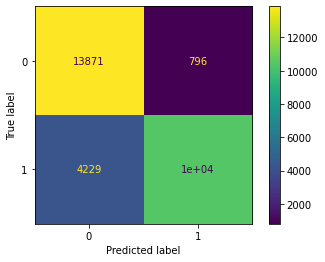

In [23]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method,'datasets/prepped_data/df_balanced_WN.csv','datasets/comp_WN.csv')

In [25]:
comp_pred = estimator.predict(comp_WN[['sentence', 'synonyms']])

In [56]:
comparison_file2 = pd.read_csv('datasets/comparison_file2.csv', error_bad_lines=False)
comparison_file2.head()

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


b'Skipping line 17: expected 1 fields, saw 2\n'


,sentence
0,Ignoring a phone call.
1,Ignoring an unknown phone call.
2,Ignoring an important phone call.
3,Ignoring an important phone call when you are ...
4,Ignoring a phone call when you are on a bus.


In [57]:
all_synonyms = []

for sentence in comparison_file2['sentence']:
    synonyms = []
    for word in sentence.split():
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.append(l.name())
                
    all_synonyms.append(synonyms)

print(all_synonyms)
print(len(all_synonyms))

[['ignore', 'disregard', 'snub', 'cut', 'dismiss', 'disregard', 'brush_aside', 'brush_off', 'discount', 'push_aside', 'ignore', 'ignore', 'neglect', 'ignore', 'disregard', 'ignore', 'angstrom', 'angstrom_unit', 'A', 'vitamin_A', 'antiophthalmic_factor', 'axerophthol', 'A', 'deoxyadenosine_monophosphate', 'A', 'adenine', 'A', 'ampere', 'amp', 'A', 'A', 'a', 'A', 'type_A', 'group_A', 'telephone', 'phone', 'telephone_set', 'phone', 'speech_sound', 'sound', 'earphone', 'earpiece', 'headphone', 'phone', 'call', 'telephone', 'call_up', 'phone', 'ring'], ['ignore', 'disregard', 'snub', 'cut', 'dismiss', 'disregard', 'brush_aside', 'brush_off', 'discount', 'push_aside', 'ignore', 'ignore', 'neglect', 'ignore', 'disregard', 'ignore', 'Associate_in_Nursing', 'AN', 'unknown', 'unknown_region', 'terra_incognita', 'stranger', 'alien', 'unknown', 'unknown', 'unknown_quantity', 'unknown', 'nameless', 'unidentified', 'unknown', 'unnamed', 'unknown', 'obscure', 'unknown', 'unsung', 'strange', 'unknown'

In [58]:
comparison_file2['synonyms'] = all_synonyms
comparison_file2.to_csv('datasets/comp_WN2.csv')
comp_WN2 = pd.read_csv('datasets/comp_WN2.csv')
comp_WN2

,Unnamed: 0,sentence,synonyms
0,0,Ignoring a phone call.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
1,1,Ignoring an unknown phone call.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
2,2,Ignoring an important phone call.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
3,3,Ignoring an important phone call when you are ...,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
4,4,Ignoring a phone call when you are on a bus.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
5,5,Ignoring a phone call if you hate the caller.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
6,6,Ignoring a phone call if the phone call is urg...,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
7,7,Ignoring a phone call when you can’t speak at ...,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
8,8,Ignoring a phone call from your parents.,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."
9,9,Ignoring a phone call from your parents who ab...,"['ignore', 'disregard', 'snub', 'cut', 'dismis..."


In [59]:
comp_pred2 = estimator.predict(comp_WN2[['sentence', 'synonyms']])

In [60]:
comp_pred2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])